# Pulse simulation demo

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import scipy.optimize as sciopt
import h5py
from IPython.display import Math
import qutip as qtp

from qudit_sim import make_generalized_paulis, make_prod_basis, heff_expr, make_tlist, run_pulse_sim, find_heff, find_gate

twopi = 2. * np.pi

pauli_labels = ['I', 'X', 'Y', 'Z']

## Input: ibmq_lima (5 qubits) Hamiltonian parameters

In [2]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_lima')

params = backend.configuration().hamiltonian['vars']

# Adding the crosstalk matrix which is not provided by IBM
# Element [i, j] of the matrix = attenuation * phase shift of drive on channel i felt by qudit j
# Qudit ordering in the crosstalk matrix follows that given as the `qubits` argument
# Values below are **completely random and not representative of the actual machine at all**
params_with_crosstalk = copy.deepcopy(params)
params_with_crosstalk['crosstalk'] = np.array([[1., 0.02 * np.exp(np.pi / 4. * 1.j)], [0.02, 1.]], dtype=np.complex128)

## [Demo 1] Single qubit, resonant drive (=Rx/Ry gate)

In [3]:
# Drive definition: square (i.e. constant) drive to channel 0 (connected to qubit 0) at the resonant frequency
# 'amplitude' is relative to the full drive amplitude ('omegad0' in params)
drive_def = {0: {'frequency': params['wq0'], 'amplitude': 0.5}}

heff = find_heff(
    qubits=0,
    params=params,
    drive_def=drive_def,
    save_result_to='demo1')

# Heff coefficients for [I, X, Y, Z]/sqrt(2) in radians / s
print(heff)

[-3.27439339e-08  4.00088206e+08  1.66646838e-08 -8.96231063e-09]


### Effective Hamiltonian

In [4]:
Math(heff_expr(heff))

<IPython.core.display.Math object>

### Raw data from the dynamics simulation

In [5]:
# Raw and processed results from the dynamics simulation is saved to `save_result_to`.h5
with h5py.File('demo1.h5', 'r') as source:
    eigenvalues = source['omega'][:]
    pauli_coeffs = source['pauli_coeffs'][:]
    tlist = source['tlist'][:]

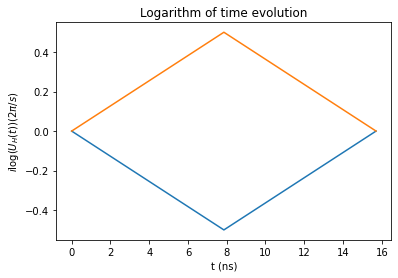

In [6]:
plt.plot(tlist * 1.e+9, eigenvalues / twopi)
plt.title('Logarithm of time evolution')
plt.ylabel(r'$i\log(U_{H}(t)) (2\pi/s)$')
plt.xlabel('t (ns)');

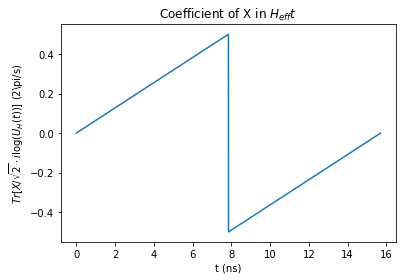

In [7]:
plt.plot(tlist * 1.e+9, pauli_coeffs[:, 1] / twopi)
plt.title(r'Coefficient of X in $H_{eff} t$')
plt.ylabel(r'$Tr[X/\sqrt{2} \cdot i\log(U_{H}(t))]$ (2\pi/s)')
plt.xlabel('t (ns)');

### Running the pulse simulation by itself

The library also exposes the API to run the dynamics simulation.

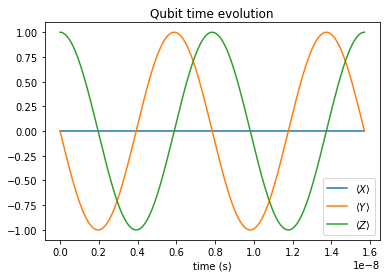

In [8]:
# Initial state: qubit |0>
psi0 = qtp.basis(2, 0)

# Observables to track:
e_ops = [qtp.sigmax(), qtp.sigmay(), qtp.sigmaz()]

result = run_pulse_sim(
    qubits=0,
    params=params,
    drive_def=drive_def,
    tlist=(10, 100), # 10 time points per drive cycle * 100 cycles
    e_ops=e_ops)

# result is a qutip.solver.Result object

plt.plot(result.times, result.expect[0], label=r'$\langle X \rangle$')
plt.plot(result.times, result.expect[1], label=r'$\langle Y \rangle$')
plt.plot(result.times, result.expect[2], label=r'$\langle Z \rangle$')
plt.title('Qubit time evolution')
plt.xlabel('time (s)')
plt.legend()

## [Demo 2] Two qubits with crosstalk, cross-resonance drive

In [9]:
# Drive definition: square (i.e. constant) drive to channel 0 at the frequency of qubit 1
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.1}}

# The function gives out a "fit failed" warning unless warn_fit_failure=False.
# Most of the time this simply means that the effective Hamiltonian term is zero, but
# in certain cases they should be followed up by manually inspecting the fit.
heff = find_heff(
    qubits=(0, 1),
    params=params_with_crosstalk,
    drive_def=drive_def,
    save_result_to='demo2')

# Heff coefficients for [[II, IX, IY, IZ], .., [ZI, ZX, ZY, ZZ]]/2 in rad / s
print(heff.shape)

(4, 4)


The returned array has two dimensions corresponding to $I, X, Y, Z$ for the first and the second qubits, respectively.

### Effective Hamiltonian

In [10]:
Math(heff_expr(heff))

<IPython.core.display.Math object>

## [Demo 3] Two qubits with no crosstalk, simulated in higher-dimensional spaces

In [11]:
# Drive definition: square (i.e. constant) drive to channel 0 at the frequency of qubit 1
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.1}}

# Qutrit simulation
heff_3 = find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    num_sim_levels=3,
    comp_dim=2,
    save_result_to='demo3-3levels')

# Qutrit simulation
heff_4 = find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    num_sim_levels=4,
    comp_dim=2,
    save_result_to='demo3-4levels')

In [12]:
Math(heff_expr(heff_3))

<IPython.core.display.Math object>

In [13]:
Math(heff_expr(heff_4))

<IPython.core.display.Math object>

## [Demo 4] Amplitude scan of two qubits with crosstalk, simulated in the qutrit space

In [14]:
amplitudes = np.linspace(-0.2, 0.2, 20)
coeffs = np.empty((amplitudes.shape[0], 4, 4), dtype='f8')

for iamp, amp in enumerate(amplitudes):
    drive_def = {0: {'frequency': params['wq1'], 'amplitude': amp}}

    coeffs[iamp] = find_heff(
        qubits=(0, 1),
        params=params_with_crosstalk,
        drive_def=drive_def,
        num_sim_levels=3,
        comp_dim=2,
        warn_fit_failure=False)

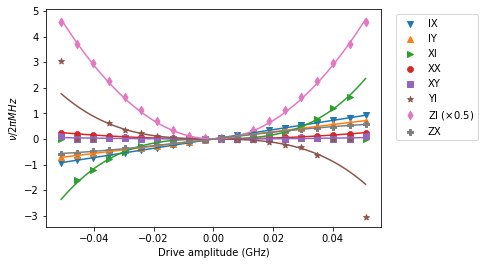

In [15]:
filled_markers = MarkerStyle.filled_markers

coeffs_MHz = coeffs / (twopi * 1.e+6)

curve_even = lambda x, a: a * np.power(x, 2)
curve_odd = lambda x, a, b: a * x + b * np.power(x, 3)
exprs = []

amplitudes_fine = np.linspace(amplitudes[0], amplitudes[-1], 100)

for ic in range(1, 16):
    i0, i1 = np.unravel_index(ic, (4, 4))
    
    nu = coeffs_MHz[:, i0, i1]
    
    # Ignoring terms weaker than 100 kHz
    if np.all(np.abs(nu) < 0.1):
        continue
        
    if np.any(np.abs(nu) > 5.):
        plot_scale = 0.5
        label = f'{pauli_labels[i0]}{pauli_labels[i1]}' + r' ($\times 0.5$)'
    else:
        plot_scale = 1.
        label = f'{pauli_labels[i0]}{pauli_labels[i1]}'
        
    if nu[5] * nu[-5] > 0.:
        curve = curve_even
    else:
        curve = curve_odd
        
    # Somehow XI and YI seem to have outliers
    if (i0, i1) in [(1, 0), (2, 0)]:
        popt, _ = sciopt.curve_fit(curve, amplitudes[3:-3], nu[3:-3])
    else:
        popt, _ = sciopt.curve_fit(curve, amplitudes, nu)
    
    omegad0 = params['omegad0'] / (twopi * 1.e+9) # In GHz
    
    pathcol = plt.scatter(amplitudes * omegad0, nu * plot_scale, marker=filled_markers[ic % len(filled_markers)], label=label)
    plt.plot(amplitudes_fine * omegad0, curve(amplitudes_fine, *popt) * plot_scale, color=pathcol.get_edgecolor())
    
    if curve is curve_even:
        c2 = popt[0] / omegad0 ** 2
        exprs.append(r'\frac{\nu_{%s%s}}{2\pi\mathrm{MHz}} = %.2f A^2' % (pauli_labels[i0], pauli_labels[i1], c2))
    else:
        c1 = popt[0] / omegad0
        c3 = popt[1] / omegad0 ** 3
        exprs.append(r'\frac{\nu_{%s%s}}{2\pi\mathrm{MHz}} = %.2f A + %.2f A^3' % (pauli_labels[i0], pauli_labels[i1], c1, c3))

plt.xlabel(r'Drive amplitude (GHz)')
plt.ylabel(r'$\nu/2\pi MHz$')
plt.legend(bbox_to_anchor=(1.03, 1.));

In [16]:
print('A = drive amplitude in GHz')
Math(r' \\ '.join(exprs))

A = drive amplitude in GHz


<IPython.core.display.Math object>

## [Demo 5] Qutrit cross resonance with crosstalk

In [17]:
# Drive definition: square (i.e. constant) drive to channel 0 at the frequency of qubit 1
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.1}}

# Qutrit simulation
heff_pos = find_heff(
    qubits=(0, 1),
    params=params_with_crosstalk,
    drive_def=drive_def,
    num_sim_levels=4,
    comp_dim=3,
    save_result_to='demo5-pos')

# Invert the phase of the drive
drive_def[0]['amplitude'] *= -1.

# Qutrit simulation
heff_neg = find_heff(
    qubits=(0, 1),
    params=params_with_crosstalk,
    drive_def=drive_def,
    num_sim_levels=4,
    comp_dim=3,
    save_result_to='demo5-neg')

Linear fit for coefficient of (4, 5) did not yield a reliable result (minimum residual = 0.011397078475238779).
Linear fit for coefficient of (5, 4) did not yield a reliable result (minimum residual = 0.011372975632480542).
Linear fit for coefficient of (4, 5) did not yield a reliable result (minimum residual = 0.011397078475238779).
Linear fit for coefficient of (5, 4) did not yield a reliable result (minimum residual = 0.011372975632480542).


In [18]:
Math(heff_expr(heff_pos))

<IPython.core.display.Math object>

In [19]:
Math(heff_expr(heff_neg))

<IPython.core.display.Math object>

Extract the parity-even terms

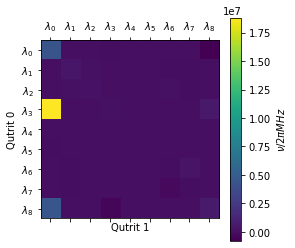

In [20]:
plt.matshow((heff_pos + heff_neg) / 2.)
plt.colorbar(label=r'$\nu/2\pi MHz$')
plt.xticks(ticks=np.arange(9), labels=[(r'$\lambda_{%d}$' % i) for i in range(9)])
plt.yticks(ticks=np.arange(9), labels=[(r'$\lambda_{%d}$' % i) for i in range(9)])
plt.ylabel('Qutrit 0')
plt.xlabel('Qutrit 1');

Parity-odd terms

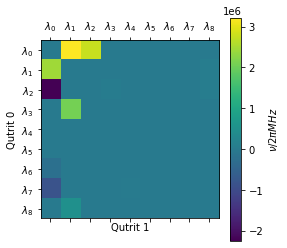

In [21]:
plt.matshow((heff_pos - heff_neg) / 2.)
plt.colorbar(label=r'$\nu/2\pi MHz$')
plt.xticks(ticks=np.arange(9), labels=[(r'$\lambda_{%d}$' % i) for i in range(9)])
plt.yticks(ticks=np.arange(9), labels=[(r'$\lambda_{%d}$' % i) for i in range(9)])
plt.ylabel('Qutrit 0')
plt.xlabel('Qutrit 1');

Coefficients greater than 100 kHz

Text(0, 0.5, '$\\nu/2\\pi MHz$')

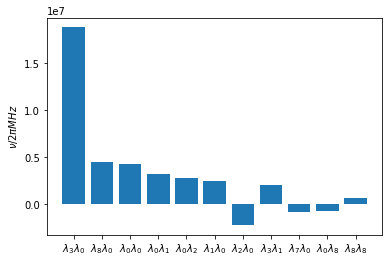

In [22]:
indices = np.argsort(-np.abs(np.ravel(heff_pos)))
nterms = len(np.asarray(np.abs(heff_pos) > 0.1 * twopi * 1.e+6).nonzero()[0])
indices = indices[:nterms]
plt.bar(np.arange(nterms), np.ravel(heff_pos)[indices])
plt.xticks(np.arange(nterms), labels=list(r'$\lambda_{%d}\lambda_{%d}$' % (i, j) for i, j in zip(*np.unravel_index(indices, (9, 9)))));
plt.ylabel(r'$\nu/2\pi MHz$')

Amplitude dependency of the coefficients

In [23]:
amplitudes = np.linspace(-0.2, 0.2, 20)
coeffs = np.empty((amplitudes.shape[0], 9, 9), dtype='f8')

for iamp, amp in enumerate(amplitudes):
    drive_def = {0: {'frequency': params['wq1'], 'amplitude': amp}}
    
    coeffs[iamp] = find_heff(
        qubits=(0, 1),
        params=params_with_crosstalk,
        drive_def=drive_def,
        num_sim_levels=4,
        comp_dim=3,
        warn_fit_failure=False)

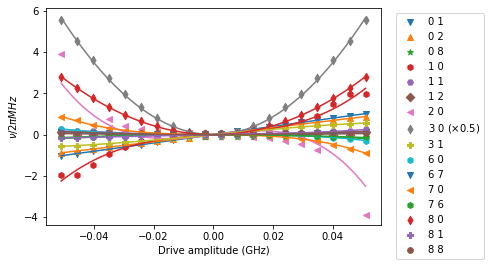

In [24]:
filled_markers = MarkerStyle.filled_markers

coeffs_MHz = coeffs / (twopi * 1.e+6)

curve_even = lambda x, a: a * np.power(x, 2)
curve_odd = lambda x, a, b: a * x + b * np.power(x, 3)
exprs = []

amplitudes_fine = np.linspace(amplitudes[0], amplitudes[-1], 100)

for ic in range(1, 81):
    i0, i1 = np.unravel_index(ic, (9, 9))
    
    nu = coeffs_MHz[:, i0, i1]
    
    # Ignoring terms weaker than 100 kHz
    if np.all(np.abs(nu) < 0.1):
        continue
        
    if np.any(np.abs(nu) > 5.):
        plot_scale = 0.5
        label = f'{i0} {i1}' + r' ($\times 0.5$)'
    else:
        plot_scale = 1.
        label = f'{i0} {i1}'
        
    if nu[5] * nu[-5] > 0.:
        curve = curve_even
    else:
        curve = curve_odd
        
    popt, _ = sciopt.curve_fit(curve, amplitudes, nu)
    
    omegad0 = params['omegad0'] / (twopi * 1.e+9) # In GHz
    
    pathcol = plt.scatter(amplitudes * omegad0, nu * plot_scale, marker=filled_markers[ic % len(filled_markers)], label=label)
    plt.plot(amplitudes_fine * omegad0, curve(amplitudes_fine, *popt) * plot_scale, color=pathcol.get_edgecolor())
    
    if curve is curve_even:
        c2 = popt[0] / omegad0 ** 2
        exprs.append(r'\frac{\nu_{%d %d}}{2\pi\mathrm{MHz}} = %.2f A^2' % (i0, i1, c2))
    else:
        c1 = popt[0] / omegad0
        c3 = popt[1] / omegad0 ** 3
        exprs.append(r'\frac{\nu_{%d %d}}{2\pi\mathrm{MHz}} = %.2f A + %.2f A^3' % (i0, i1, c1, c3))

plt.xlabel(r'Drive amplitude (GHz)')
plt.ylabel(r'$\nu/2\pi MHz$')
plt.legend(bbox_to_anchor=(1.03, 1.));

## [Demo 6] Finding the $\pi$ pulse

`find_gate` computes the effective unitary (gate) of a given pulse and returns the Pauli coefficients of $i\log U_{\mathrm{eff}}$.

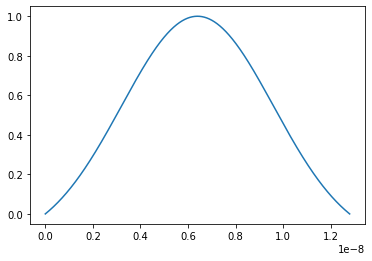

In [25]:
# "Grounded" gaussian pulse from -2 sigma to +2 sigma
sigma = 16 * 0.2e-9 # 16 clocks * 0.2 ns/clock
peak = 2. * sigma
pedestal = np.exp(-2.)
norm = 1. / (1. - pedestal)
envelope = f'(exp(-(t - {peak}) * (t - {peak}) / 2. / {sigma ** 2}) - {pedestal}) * {norm}'
tlist = np.linspace(0., 4. * sigma, 4000)

plt.plot(tlist, (np.exp(-(tlist - peak) * (tlist - peak) / 2. / (sigma ** 2)) - pedestal) * norm)

In [26]:
amplitudes = np.linspace(0., 1., 20)

x_coeff = np.empty_like(amplitudes)
z_coeff = np.empty_like(amplitudes)

for iamp, amp in enumerate(amplitudes):
    drive_def = {0: {'frequency': params['wq0'], 'amplitude': f'{amp} * {envelope}'}}

    rx_gate = find_gate(
        qubits=0,
        params=params,
        drive_def=drive_def,
        tlist=tlist,
        num_sim_levels=3,
        comp_dim=2
    )

    x_coeff[iamp] = rx_gate[1]
    z_coeff[iamp] = rx_gate[3]

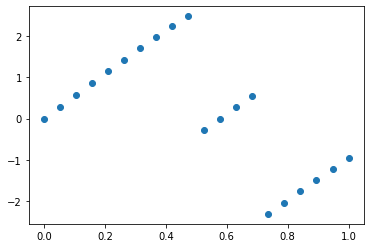

In [27]:
plt.scatter(amplitudes, x_coeff)

The eigenvalues of $i \log U_{\mathrm{eff}}$ seemed to have jumped after the 10th point. Fit a line to data points before the jump.

Pi pulse realized at amplitude 0.2931216671943215


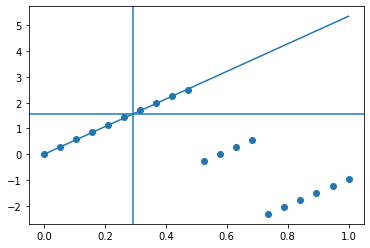

In [28]:
popt, _ = sciopt.curve_fit(lambda x, a: a * x, amplitudes[:10], x_coeff[:10])

# pi pulse -> Ueff = exp(-i pi/2 X)
pipulse_amp = np.pi / 2. / popt[0]
print(f'Pi pulse realized at amplitude {pipulse_amp}')

plt.scatter(amplitudes, x_coeff)
plt.plot(amplitudes, popt[0] * amplitudes)
plt.axhline(y=(np.pi / 2.))
plt.axvline(x=pipulse_amp)

Of course, with higher levels included in the simulation, a simple Gaussian pulse no longer implements a pure $R_x$ gate.

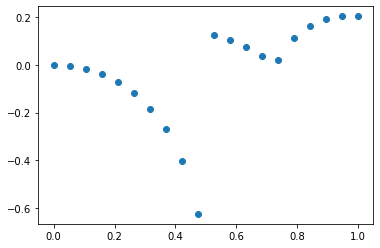

In [29]:
plt.scatter(amplitudes, z_coeff)